In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm

plt.style.use(['science', 'grid', 'notebook'])

In [2]:
# entradas de la compuerta
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
# salidas
Y = np.array([[0], [1], [1], [0]])

print(X.shape, Y.shape)

(4, 2) (4, 1)


In [3]:
activation = lambda h: np.tanh(h)
derivate_act = lambda h: 1 - np.tanh(h)**2

def begin(NI, NH, No):  # prepara los coeficientes de la red
    # Semilla aleatoria para reproducibilidad

    # red totalmente conectada con NI entrdas, NH capas ocultas y NO salidas
    # weights
    w_ih = np.random.rand(NI, NH)
    w_ho = np.random.rand(NH + NI, No)
    #bias
    b0 = np.random.rand(NH)
    b1 = np.random.rand(No)

    return (w_ih, w_ho, b0, b1)

def NN(x, w_ih, w_ho, b1, b0):#+
    # Vj = np.zeros((X.shape[0], w_ih.shape[1]))
    oi = np.zeros((X.shape[0], w_ho.shape[1]))

    for mu in range(X.shape[0]):    # itero en todos los ejemplos
        # input -> hidden
        Vj = activation(np.dot(x[mu], w_ih) + b0)
        # concateno la salida de la oculta con las entradas
        concatenated_input = np.concatenate((x[mu], Vj))
        # hidden -> output
        oi[mu] = activation(np.dot(concatenated_input, w_ho) + b1)
    
    return oi

def NN2(x, w_ih, w_ho, b1, b0):
    Vj = activation(np.dot(x, w_ih) + b0)  # Capa oculta para todas las entradas

    concatenated_input = np.concatenate((x, Vj))  # Concatenar entrada y salida oculta
    oi = activation(np.dot(concatenated_input, w_ho) + b1)  # Capa de salida
    return oi

# Function to perform training with mini-batch gradient descent
def train(epochs, x_train, y_train, lr, w_ih, w_ho, b0, b1, act, grad_act, batch_size=32, epsilon=0.01, mse_convergence=0.05):
    num_samples = x_train.shape[0]  # Total number of samples
    accuracies = np.zeros(epochs)
    mse = np.zeros(epochs)
    convergence_time = 0
    convergence_flag = False

    for i in range(epochs):
        # Shuffle data at the beginning of each epoch
        indices = np.random.permutation(num_samples)
        x_shuffled = x_train[indices]
        y_shuffled = y_train[indices]

        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            x_batch = x_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Initialize gradients
            grad_w_0_1 = np.zeros_like(w_ih)
            grad_w_1_2 = np.zeros_like(w_ho)
            grad_b0 = np.zeros_like(b0)
            grad_b1 = np.zeros_like(b1)

            # Forward projection for the mini-batch
            hj = np.dot(x_batch, w_ih) + b0  # Shape: (batch_size, hidden_dim)
            Vj = act(hj)  # Apply activation function element-wise
            concatenate_input = np.concatenate((x_batch, Vj), axis=1)  # Shape: (batch_size, input_dim + hidden_dim)
            hi = np.dot(concatenate_input, w_ho) + b1  # Shape: (batch_size, output_dim)
            oi = act(hi)  # Apply activation function element-wise

            # Backpropagation
            # hidden -> output
            delta_i_mu = grad_act(hi) * (y_batch - oi)  # Shape: (batch_size, output_dim)
            grad_w_1_2 += np.dot(concatenate_input.T, delta_i_mu)  # Update weights (input_dim + hidden_dim, output_dim)
            grad_b1 += delta_i_mu.sum(axis=0)  # Sum over the batch

            # input -> hidden
            delta_j_mu = grad_act(hj) * np.dot(delta_i_mu, w_ho[x_batch.shape[1]:].T)  # Shape: (batch_size, hidden_dim)
            grad_w_0_1 += np.dot(x_batch.T, delta_j_mu)  # Update weights (input_dim, hidden_dim)
            grad_b0 += delta_j_mu.sum(axis=0)  # Sum over the batch
            
            # Métricas
            accuracies[i] += np.sum(np.abs(oi.flatten() - y_batch.flatten()) < epsilon)  # Accuracy
            mse[i] += np.sum((oi.flatten() - y_batch.flatten()) ** 2)  # MSE

            # Actualizo los pesos y los bias
            w_ih += lr * grad_w_0_1
            w_ho += lr * grad_w_1_2
            b0 += lr * grad_b0
            b1 += lr * grad_b1

        if mse[i] <= mse_convergence and not convergence_flag:
            convergence_time = i
            convergence_flag = True
            
    metrics = {'accuracy': accuracies / len(y_train), 'mse': mse / len(y_train),'convergence_time': convergence_time}

    return w_ih, w_ho, b0, b1, metrics


In [4]:
epochs = 2000

NI, NH = 2, 2
No = 1
learning_rate = 0.1

n_sorts = 10

accuracies = np.empty((n_sorts, epochs))
mses = np.empty((n_sorts, epochs))
times = np.empty(n_sorts)

# seeds = [45, 32, 12, 98, 12, 2, 21, 67, 32, 71]
# seeds= [42]
np.random.seed(12)

for i in range(n_sorts):
    # BEGIN
    weights = begin(NI, NH, No)
    #TRAIN
    w_ih, w_ho, b0, b1, metrics = train(epochs, X, Y, learning_rate, *weights, activation, derivate_act,batch_size=4,  epsilon=0.1)
    
    # TEST
    print('Sort: ', i)
    oi = NN(X, w_ih, w_ho, b1, b0)

    for j in range(oi.shape[0]):
        print(f'Input {X[j]}, Output {Y[j]}, Predicted {oi[j]}')

    accuracies[i] = metrics['accuracy']
    mses[i] = metrics['mse']
    times[i] = metrics['convergence_time']

# weights = begin(NI, NH, No)

# w_ih, w_ho, b0, b1, metrics = train(epochs, X, Y, *weights, learning_rate, activation, derivate_act, batch_size=32, epsilon=0.1)

# oi = NN(X, w_ih, w_ho, b1, b0)

# for i in range(oi.shape[0]):
#     print(f'Input {X[i]}, Output {Y[i]}, Predicted {oi[i]}')


Sort:  0
Input [0 0], Output [0], Predicted [0.00080792]
Input [0 1], Output [1], Predicted [0.95989708]
Input [1 0], Output [1], Predicted [0.95984393]
Input [1 1], Output [0], Predicted [0.0047233]
Sort:  1
Input [0 0], Output [0], Predicted [0.00074869]
Input [0 1], Output [1], Predicted [0.96020404]
Input [1 0], Output [1], Predicted [0.96026722]
Input [1 1], Output [0], Predicted [0.00463432]
Sort:  2
Input [0 0], Output [0], Predicted [0.00062856]
Input [0 1], Output [1], Predicted [0.95828035]
Input [1 0], Output [1], Predicted [0.9604629]
Input [1 1], Output [0], Predicted [0.0046404]
Sort:  3
Input [0 0], Output [0], Predicted [0.00074892]
Input [0 1], Output [1], Predicted [0.960898]
Input [1 0], Output [1], Predicted [0.96101426]
Input [1 1], Output [0], Predicted [0.00448384]
Sort:  4
Input [0 0], Output [0], Predicted [0.00068225]
Input [0 1], Output [1], Predicted [0.95772715]
Input [1 0], Output [1], Predicted [0.95791457]
Input [1 1], Output [0], Predicted [0.00507229]


392.0
0.012454264281902806
335.0
0.012457701079447669
361.0
0.012498686828454363
308.0
0.012492257167111925
431.0
0.012457541840134381
305.0
0.012493883947849841
400.0
0.012488611833183443
857.0
0.012486242141037034
316.0
0.012479122604874562
368.0
0.012479014568878361
Mean convergence time: 407.3 +- 15.51309446886726


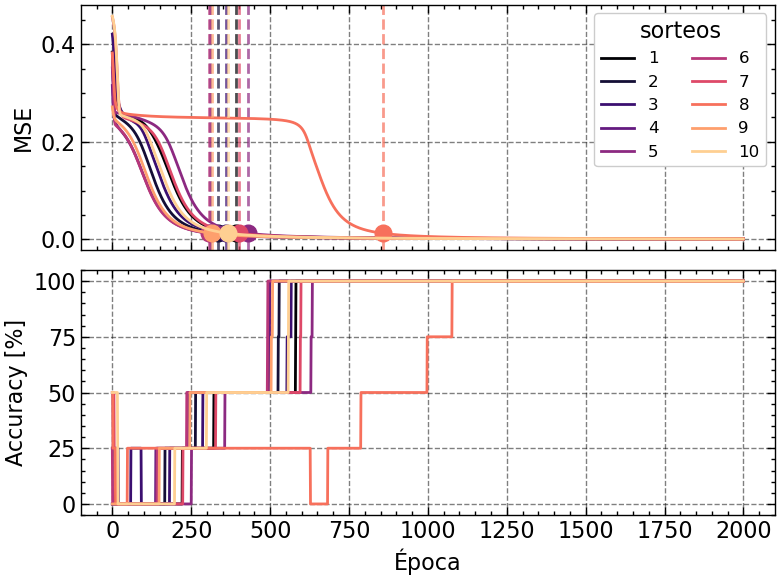

In [5]:
cm = plt.get_cmap('magma')

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for i in range(n_sorts):
    ax[1].plot(accuracies[i]*100, label=i+1, color=cm(i/n_sorts))
    ax[0].plot(mses[i], label=i+1, color=cm(i/n_sorts))
    print(times[i])
    if not np.isnan(times[i]):
        print(mses[i][int(times[i])])
        ax[0].plot(times[i], mses[i][int(times[i])], 'o', color=cm(i/n_sorts), ms=12)
        ax[0].axvline(times[i], color=cm(i/n_sorts), linestyle='--', lw=2, alpha=0.7)
    else:
        print('No convergió')
    # ax[0].plot([times[i]], [mses[i][times[i]]], 'o')
    # ax[1].axvline(times[i], color=cm(i/n_sorts), linestyle='--')
    # plt.show()
    # plt.title(f'Sort {i+1}')

ax[0].legend(fontsize=12, ncols=2, title='sorteos')

ax[1].set_ylabel('Accuracy [%]')
ax[0].set_ylabel('MSE')
ax[1].set_xlabel('Época')
plt.tight_layout()

print(f'Mean convergence time: {times.mean()} +- {times.std()/len(times)}')

# plt.savefig('../doc/figures/metrics_e1_2.pdf', dpi=500)
# plt.yscale('log')